In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
import os
from glob import glob

# --- Parámetros generales ---
FS = 50             # Frecuencia muestreo acelerómetro (Hz)
FPS = 25            # Frecuencia anotaciones (video)
SEGMENT_START = 0   # Segundo inicial del segmento vid2_seg7
WINDOW_SIZE = 100   # 2 segundos
STEP_SIZE = 50      # 50% solapamiento
COLS = ['accelX', 'accelY', 'accelZ']

# --- Cargar anotaciones ---
#ann = pd.read_csv('/Volumes/staff-bulk/ewi/insy/SPCDataSets/conflab-mm/v4/release/annotations/actions/laughing/Only_Audio/vid2_seg7_ann1.csv')


# --- Ruta base de todas las anotaciones ---
ANNOTATION_BASE = '/Volumes/staff-bulk/ewi/insy/SPCDataSets/conflab-mm/v4/release/annotations/actions/laughing'

# --- Subcarpetas con las categorías ---
SOURCE_TYPES = ['No_Audio', 'Only_Audio', 'With_Audio']

# --- Cargar rutas de archivos .csv agrupados por fuente ---
annotation_files = []

for src_type in SOURCE_TYPES:
    folder = os.path.join(ANNOTATION_BASE, src_type)
    files = sorted(glob(os.path.join(folder, '*.csv')))
    for f in files:
        annotation_files.append({
            "source": src_type,
            "path": f,
            "filename": os.path.basename(f),
            "video_id": os.path.basename(f).split('_')[0],   # e.g. vid2
            "segment": os.path.basename(f).split('_')[1],    # e.g. seg7
            "annotator": os.path.basename(f).split('_')[2].replace('.csv', '')  # e.g. ann1
        })


In [3]:
for ann_meta in annotation_files:
    print(f"\n📥 Procesando: {ann_meta['filename']} ({ann_meta['source']})")

    try:
        ann = pd.read_csv(
            ann_meta["path"],
            encoding='latin1',
            on_bad_lines='skip'
        )

        # Si el archivo está vacío o sin columnas válidas, lo saltamos
        if ann.empty or ann.shape[1] == 0:
            print(f"⚠️ Archivo vacío o sin columnas: {ann_meta['filename']}. Saltado.")
            continue

    except Exception as e:
        print(f"❌ Error cargando {ann_meta['filename']}: {e}")
        continue

    print(f"✅ Archivo cargado con éxito: {ann.shape[0]} filas, {ann.shape[1]} columnas")

    # Aquí continuarías con el procesamiento




📥 Procesando: vid2_seg7_ann1.csv (No_Audio)
✅ Archivo cargado con éxito: 7276 filas, 23 columnas

📥 Procesando: vid2_seg7_ann2.csv (No_Audio)
❌ Error cargando vid2_seg7_ann2.csv: Error tokenizing data. C error: EOF inside string starting at row 33156

📥 Procesando: vid2_seg7_ann3.csv (No_Audio)


/var/folders/75/lrrp6ghd2csd748_l4sy8y0c0000gn/T/ipykernel_41720/795775236.py:5: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  ann = pd.read_csv(


✅ Archivo cargado con éxito: 32987 filas, 31 columnas

📥 Procesando: vid2_seg8_ann1.csv (No_Audio)
✅ Archivo cargado con éxito: 7204 filas, 34 columnas

📥 Procesando: vid2_seg8_ann2.csv (No_Audio)


/var/folders/75/lrrp6ghd2csd748_l4sy8y0c0000gn/T/ipykernel_41720/795775236.py:5: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  ann = pd.read_csv(


✅ Archivo cargado con éxito: 16699 filas, 32 columnas

📥 Procesando: vid2_seg8_ann3.csv (No_Audio)
✅ Archivo cargado con éxito: 7272 filas, 34 columnas

📥 Procesando: vid2_seg9_ann1.csv (No_Audio)
❌ Error cargando vid2_seg9_ann1.csv: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


📥 Procesando: vid2_seg9_ann2.csv (No_Audio)
✅ Archivo cargado con éxito: 6445 filas, 36 columnas

📥 Procesando: vid2_seg9_ann3.csv (No_Audio)
✅ Archivo cargado con éxito: 6144 filas, 38 columnas

📥 Procesando: vid3_seg1_ann1.csv (No_Audio)
✅ Archivo cargado con éxito: 7200 filas, 39 columnas

📥 Procesando: vid3_seg1_ann2.csv (No_Audio)
✅ Archivo cargado con éxito: 7200 filas, 42 columnas

📥 Procesando: vid3_seg1_ann3.csv (No_Audio)
✅ Archivo cargado con éxito: 7391 filas, 39 columnas

📥 Procesando: vid3_seg2_ann1.csv (No_Audio)
✅ Archivo cargado con éxito: 7201 filas, 42 columnas

📥 Procesando: vid3_seg2_ann2.csv (No_Audio)
✅ Archivo cargado con éxito: 7200 filas, 43 

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    return butter(order, [low, high], btype='band')
#Esto sirve para bloquear freq debajo o por ensima de los parametros

def apply_filter(signal, lowcut=0.5, highcut=10.0, fs=50):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, signal)
#Aplicar el filtro


In [5]:
def segment_signal(df, window_size, step_size, columns):
    segments, starts = [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        segments.append(df[columns].iloc[start:end].values)
        starts.append(df['time'].iloc[start])
    return np.array(segments), np.array(starts)
#Divide la señal completa en segmentos de tamaños especiifos

In [29]:
import numpy as np

def extract_features(segment):
    # segment shape: (window_size, 3) — for accelX_filt, accelY_filt, accelZ_filt
    x, y, z = segment[:, 0], segment[:, 1], segment[:, 2]

    features = []

    # Por eje (mean, std, max, min, energy)
    for axis_data in [x, y, z]:
        features.extend([
            np.mean(axis_data),
            np.std(axis_data),
            np.max(axis_data),
            np.min(axis_data),
            np.sum(axis_data ** 2),  # Energy
        ])

    # Signal Magnitude Area (SMA)
    sma = np.mean(np.abs(x) + np.abs(y) + np.abs(z))
    features.append(sma)

    # Correlación entre ejes (X-Y, X-Z, Y-Z)
    features.append(np.corrcoef(x, y)[0, 1])
    features.append(np.corrcoef(x, z)[0, 1])
    features.append(np.corrcoef(y, z)[0, 1])

    return features


In [30]:
# --- Cargar señales de acelerómetro UNA SOLA VEZ por participante ---
df_dict = {}

for pid in range(1, 51):
    try:
        df = pd.read_csv(
            f'/Volumes/staff-bulk/ewi/insy/SPCDataSets/conflab-mm/v4/release/data_processed/wearables/{pid}.csv',
            usecols=COLS,
            encoding='latin1',
            on_bad_lines='skip'
        )
        for col in COLS:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df.dropna(subset=COLS, inplace=True)
        df['time'] = np.arange(len(df)) / FS

        # Aplicar filtro y normalización una vez
        for axis in COLS:
            df[f'{axis}_filt'] = apply_filter(df[axis])
        scaler = StandardScaler()
        df[[f'{c}_filt' for c in COLS]] = scaler.fit_transform(df[[f'{c}_filt' for c in COLS]])

        df_dict[pid] = df
        print(f"✅ Señal cargada para participante {pid}")

    except Exception as e:
        print(f"❌ Error cargando señal de participante {pid}: {e}")


✅ Señal cargada para participante 1
✅ Señal cargada para participante 2
✅ Señal cargada para participante 3
✅ Señal cargada para participante 4
✅ Señal cargada para participante 5
✅ Señal cargada para participante 6
✅ Señal cargada para participante 7
✅ Señal cargada para participante 8
✅ Señal cargada para participante 9
✅ Señal cargada para participante 10
✅ Señal cargada para participante 11
✅ Señal cargada para participante 12
✅ Señal cargada para participante 13
✅ Señal cargada para participante 14
✅ Señal cargada para participante 15
✅ Señal cargada para participante 16
✅ Señal cargada para participante 17
✅ Señal cargada para participante 18
✅ Señal cargada para participante 19
✅ Señal cargada para participante 20
✅ Señal cargada para participante 21
✅ Señal cargada para participante 22
✅ Señal cargada para participante 23
✅ Señal cargada para participante 24
✅ Señal cargada para participante 25
✅ Señal cargada para participante 26
✅ Señal cargada para participante 27
✅ Señal ca

In [31]:
# --- Diccionario de tiempos por video (inicio, fin en segundos) ---
video_segments = {
    'vid2_seg7':  (0, 120),
    'vid2_seg8':  (120, 240),
    'vid2_seg9':  (240, 338),
    'vid3_seg1':  (338, 458),
    'vid3_seg2':  (458, 578),
    'vid3_seg3':  (578, 698),
    'vid3_seg4':  (698, 818),
    'vid3_seg5':  (818, 938),
    'vid3_seg6':  (938, 1058),
    'vid3_seg7':  (1058, 1178),
    'vid3_seg8':  (1178, 1298),
    'vid3_seg9':  (1298, 1396),
    'vid4_seg1':  (1396, 1516),
    'vid4_seg2':  (1516, 1636),
    'vid4_seg3':  (1636, 1756),
    'vid4_seg4':  (1756, 1876),
    'vid4_seg5':  (1876, 1996),
    'vid4_seg6':  (1996, 2116),
    'vid4_seg7':  (2116, 2236),
    'vid4_seg8':  (2236, 2356),
    'vid4_seg9':  (2356, 2454),
    'vid5_seg1':  (2454, 2574),
    'vid5_seg2':  (2574, 2694),
}

# --- Dataset final + resumen ---
X_total = []
y_total = []
resumen_data = []

for ann_meta in annotation_files:
    #print(f"\n📁 Procesando anotaciones: {ann_meta['filename']} ({ann_meta['source']})")

    try:
        ann = pd.read_csv(ann_meta["path"], encoding='latin1', on_bad_lines='skip')
        if ann.empty or ann.shape[1] == 0:
            #print(f"⚠️ Archivo vacío o inválido. Saltado.")
            continue
    except Exception as e:
        print(f"❌ Error leyendo anotaciones: {e}")
        continue

    # Obtener clave del segmento (ej: vid2_seg7)
    segment_key = f"{ann_meta['video_id']}_{ann_meta['segment']}"
    if segment_key not in video_segments:
        #print(f"⚠️ Segmento no registrado en tabla de tiempos: {segment_key}. Saltado.")
        continue

    start_t, end_t = video_segments[segment_key]
    available_pids = [col for col in ann.columns if col.isnumeric()]

    for str_pid in available_pids:
        pid = int(str_pid)

        if pid not in df_dict:
            #print(f"⚠️ Participante {pid} no tiene señal cargada. Saltado.")
            continue

        df_full = df_dict[pid]
        df = df_full[(df_full['time'] >= start_t) & (df_full['time'] < end_t)].copy()
        if df.empty:
            continue

        segments, starts = segment_signal(df, WINDOW_SIZE, STEP_SIZE, [f'{c}_filt' for c in COLS])
        if len(segments) == 0:
            continue

        #features = [extract_features(seg) for seg in segments]
        features = [extract_features(seg) for seg in segments]
        centers = starts + (WINDOW_SIZE / (2 * FS))

        #Esto asegura que label_vector sea un array de tipo float64, que es lo que np.interp() necesita.
        col_serie = pd.to_numeric(ann[str_pid], errors='coerce').fillna(0)
        label_vector = col_serie.values.astype(float)

        label_times = np.arange(len(label_vector)) / FPS

        valid_idx = (centers >= label_times[0]) & (centers <= label_times[-1])
        if valid_idx.sum() == 0:
            continue

        valid_centers = centers[valid_idx]
        valid_features = [features[i] for i in range(len(features)) if valid_idx[i]]

        #Get the average label from the window
        #Other option to do so manually using %
        labels_interp = np.interp(valid_centers, label_times, label_vector)
        labels = [int(round(x)) for x in labels_interp if not np.isnan(x)]

        X_total.extend(valid_features)
        y_total.extend(labels)

        # 🔍 Guardar resumen por participante-video
        resumen_data.append({
            "video": segment_key,
            "pid": pid,
            "n_segmentos": len(valid_features),
            "n_risa": sum(labels)
        })


📁 Procesando anotaciones: vid2_seg7_ann1.csv (No_Audio)

📁 Procesando anotaciones: vid2_seg7_ann2.csv (No_Audio)

📁 Procesando anotaciones: vid2_seg7_ann3.csv (No_Audio)

📁 Procesando anotaciones: vid2_seg8_ann1.csv (No_Audio)

📁 Procesando anotaciones: vid2_seg8_ann2.csv (No_Audio)

📁 Procesando anotaciones: vid2_seg8_ann3.csv (No_Audio)

📁 Procesando anotaciones: vid2_seg9_ann1.csv (No_Audio)

📁 Procesando anotaciones: vid2_seg9_ann2.csv (No_Audio)

📁 Procesando anotaciones: vid2_seg9_ann3.csv (No_Audio)

📁 Procesando anotaciones: vid3_seg1_ann1.csv (No_Audio)

📁 Procesando anotaciones: vid3_seg1_ann2.csv (No_Audio)

📁 Procesando anotaciones: vid3_seg1_ann3.csv (No_Audio)

📁 Procesando anotaciones: vid3_seg2_ann1.csv (No_Audio)

📁 Procesando anotaciones: vid3_seg2_ann2.csv (No_Audio)

📁 Procesando anotaciones: vid3_seg2_ann3.csv (No_Audio)

📁 Procesando anotaciones: vid3_seg3_ann1.csv (No_Audio)

📁 Procesando anotaciones: vid3_seg3_ann2.csv (No_Audio)

📁 Procesando anotaciones: vid3

In [32]:
# --- Reporte final ---
print("\n✅ Dataset final construido:")
print(f"  - Total ventanas: {len(X_total)}")
print(f"  - Positivas (risa): {sum(y_total)}")
print(f"  - Negativas (no risa): {len(y_total) - sum(y_total)}")



✅ Dataset final construido:
  - Total ventanas: 79373
  - Positivas (risa): 1692
  - Negativas (no risa): 77681


In [33]:
df_resumen = pd.DataFrame(resumen_data)

if not df_resumen.empty:
    df_resumen["porcentaje_risa"] = df_resumen["n_risa"] / df_resumen["n_segmentos"]

# Guardar el archivo
df_resumen.to_csv("resumen_risa.csv", index=False)
print("✅ Resumen guardado como resumen_risa.csv")

conteo = df_resumen.groupby(["video", "pid"]).size().reset_index(name="n_repeticiones")
conteo_duplicados = conteo[conteo["n_repeticiones"] > 1]
print(conteo_duplicados)

print(df_resumen.groupby("video")["n_risa"].sum().sort_values(ascending=False).head(10))

df_resumen_clean = df_resumen.drop_duplicates(subset=["video", "pid"])




✅ Resumen guardado como resumen_risa.csv
        video  pid  n_repeticiones
0   vid2_seg7    1               9
1   vid2_seg7    2               8
2   vid2_seg7    3               8
3   vid2_seg7    4               9
4   vid2_seg7    5               9
..        ...  ...             ...
91  vid2_seg8   46               3
92  vid2_seg8   47               3
93  vid2_seg8   48               4
94  vid2_seg8   49               3
95  vid2_seg8   50               3

[96 rows x 3 columns]
video
vid2_seg8    944
vid2_seg7    748
Name: n_risa, dtype: int64


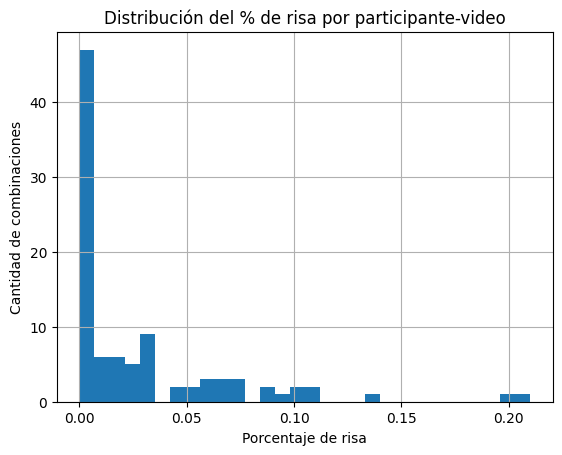

In [34]:
import matplotlib.pyplot as plt

df_resumen_clean["porcentaje_risa"].hist(bins=30)
plt.title("Distribución del % de risa por participante-video")
plt.xlabel("Porcentaje de risa")
plt.ylabel("Cantidad de combinaciones")
plt.show()


In [35]:
segmentos_mas_risa = df_resumen.groupby("video")["n_risa"].sum().reset_index()
segmentos_mas_risa = segmentos_mas_risa.sort_values("n_risa", ascending=False)
print(segmentos_mas_risa.head(10))  # Top 10 segmentos con más risas


       video  n_risa
1  vid2_seg8     944
0  vid2_seg7     748


In [ ]:
#Random Forest Classifier

Classification Report:
              precision    recall  f1-score   support

 No Laughter       0.98      0.98      0.98     15537
    Laughter       0.23      0.22      0.23       338

    accuracy                           0.97     15875
   macro avg       0.61      0.60      0.60     15875
weighted avg       0.97      0.97      0.97     15875



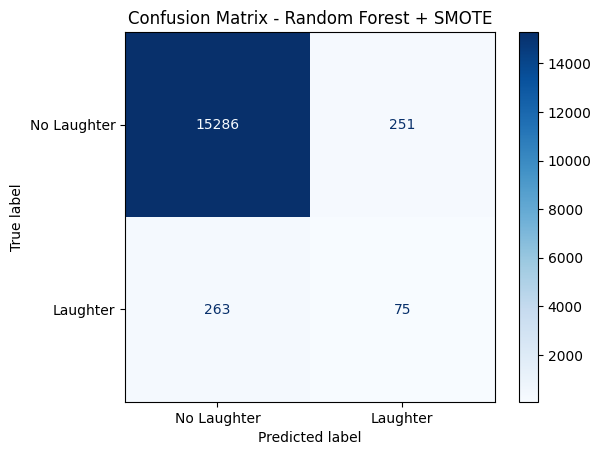

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, stratify=y_total, random_state=42
)

# 2. Balance with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# 3. Train classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_resampled, y_resampled)

# 4. Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Laughter", "Laughter"]))

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Laughter", "Laughter"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest + SMOTE")
plt.show()


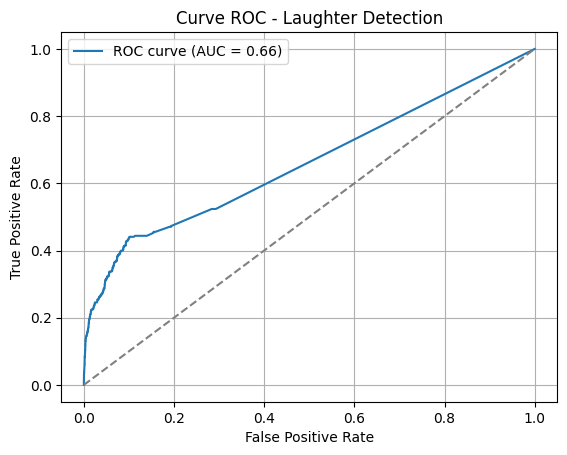

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener probabilidades de clase
y_probs = clf.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curve ROC - Laughter Detection')
plt.legend()
plt.grid()
plt.show()


In [39]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Curva precision-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Buscar el umbral con mejor F1-score
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Mejor umbral por F1-score: {best_thresh:.2f}")
print(f"Precision: {precision[best_idx]:.2f}, Recall: {recall[best_idx]:.2f}, F1: {f1_scores[best_idx]:.2f}")

# Aplicar el nuevo umbral
y_pred_adjusted = (y_probs >= best_thresh).astype(int)

# Re-evaluar
print(classification_report(y_test, y_pred_adjusted, target_names=["No Risa", "Risa"]))


Mejor umbral por F1-score: 0.75
Precision: 0.25, Recall: 0.21, F1: 0.23
              precision    recall  f1-score   support

     No Risa       0.98      0.99      0.98     15537
        Risa       0.25      0.21      0.23       338

    accuracy                           0.97     15875
   macro avg       0.62      0.60      0.61     15875
weighted avg       0.97      0.97      0.97     15875



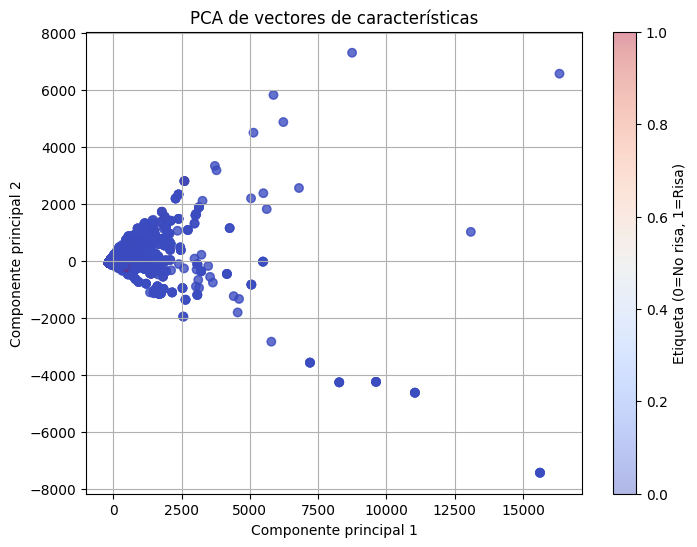

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_vis = PCA(n_components=2).fit_transform(X_total)

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_total, cmap='coolwarm', alpha=0.4)
plt.title("PCA de vectores de características")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label="Etiqueta (0=No risa, 1=Risa)")
plt.grid()
plt.show()


In [41]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
skf = StratifiedKFold(n_splits=5)

scores = cross_val_score(clf, X_total, y_total, scoring='f1', cv=skf)
print(f"F1-score promedio con validación cruzada: {scores.mean():.2f}")


F1-score promedio con validación cruzada: 0.12


Classification Report:
              precision    recall  f1-score   support

 No Laughter       0.98      0.98      0.98     15537
    Laughter       0.23      0.22      0.23       338

    accuracy                           0.97     15875
   macro avg       0.61      0.60      0.60     15875
weighted avg       0.97      0.97      0.97     15875



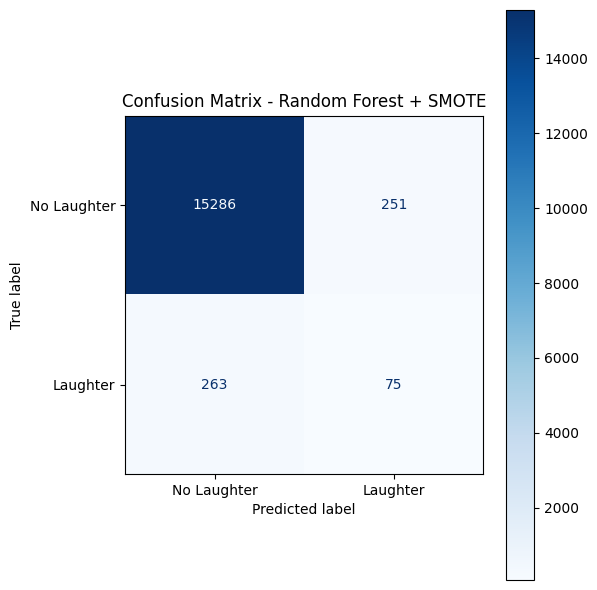

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, stratify=y_total, random_state=42)

# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_resampled, y_resampled)

# Make predictions
y_pred = clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Laughter", "Laughter"]))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Laughter", "Laughter"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix - Random Forest + SMOTE")
plt.grid(False)
plt.tight_layout()
plt.show()


Classification Report (Threshold=0.7):
              precision    recall  f1-score   support

 No Laughter       0.99      0.92      0.95     20936
    Laughter       0.10      0.39      0.16       449

    accuracy                           0.91     21385
   macro avg       0.54      0.66      0.56     21385
weighted avg       0.97      0.91      0.94     21385



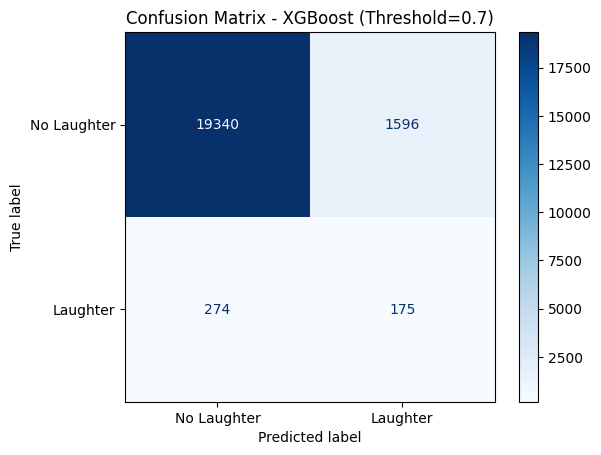

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- Ajustar el umbral manualmente ---
umbral = 0.7  # puedes experimentar con valores como 0.25, 0.4, etc.

# Obtener las probabilidades de la clase positiva (risa)
probas = xgb_clf.predict_proba(X_test_xgb)[:, 1]

# Aplicar el umbral para generar predicciones binarias
y_pred_umbral = (probas >= umbral).astype(int)

# Evaluar con el nuevo umbral
print(f"Classification Report (Threshold={umbral}):")
print(classification_report(y_test_xgb, y_pred_umbral, target_names=["No Laughter", "Laughter"]))

# Matriz de confusión
cm = confusion_matrix(y_test_xgb, y_pred_umbral)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Laughter", "Laughter"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - XGBoost (Threshold={umbral})")
plt.show()
